In [1]:
!pip install torchsummary

In [2]:
# import packages
import os
import pickle
from tqdm.notebook import tqdm
import random
from tabulate import tabulate
from torchsummary import summary
from PIL import Image
import timm

import cv2
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as t

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from torchvision import models
from torchvision.transforms.v2 import Resize, Compose, RandomHorizontalFlip, ColorJitter, RandomAffine, RandomErasing, ToTensor

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [3]:
tr_test = pd.read_csv('/kaggle/input/liver-dat/liver_new.csv')
X = list(tr_test['Paths'])
y = list(tr_test['labels'])

In [4]:
tr_test

,Unnamed: 0,Paths,labels
0,0,/kaggle/input/rsna-abdominal-trauma-detection-...,1
1,1,/kaggle/input/rsna-abdominal-trauma-detection-...,1
2,2,/kaggle/input/rsna-abdominal-trauma-detection-...,1
3,3,/kaggle/input/rsna-abdominal-trauma-detection-...,1
4,4,/kaggle/input/rsna-abdominal-trauma-detection-...,1
...,...,...,...
3270,3270,/kaggle/input/rsna-abdominal-trauma-detection-...,1
3271,3271,/kaggle/input/rsna-abdominal-trauma-detection-...,1
3272,3272,/kaggle/input/rsna-abdominal-trauma-detection-...,1
3273,3273,/kaggle/input/rsna-abdominal-trauma-detection-...,1


In [5]:
train_transforms = Compose([
                            Resize((224, 224), antialias = True),
                            RandomHorizontalFlip(),  # Randomly flip images left-right
                            ColorJitter(brightness=0.2),  # Randomly adjust brightness
#                             ColorJitter(contrast=0.2),  # Randomly adjust contrast
#                             RandomAffine(degrees=0, shear=10),  # Apply shear transformation
                            RandomAffine(degrees=0, scale=(0.9, 1.1)),  # Apply zoom transformation
                            RandomErasing(p=0.2, scale=(0.02, 0.2)), # Coarse dropout
                            ToTensor(),
                        ])
test_transforms = Compose([
                            Resize((224, 224), antialias = True),
#                             RandomHorizontalFlip(),  # Randomly flip images left-right
#                             ColorJitter(brightness=0.2),  # Randomly adjust brightness
#                             ColorJitter(contrast=0.2),  # Randomly adjust contrast
# #                             RandomAffine(degrees=0, shear=10),  # Apply shear transformation
#                             RandomAffine(degrees=0, scale=(0.9, 1.1)),  # Apply zoom transformation
#                             RandomErasing(p=0.2, scale=(0.02, 0.2)), # Coarse dropout
                            ToTensor(),
                        ])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [6]:
img = Image.open(tr_test['Paths'][0]).convert('RGB')

In [7]:
# dataset
class LiverData(Dataset):
    
    def __init__(self, paths, labels, transform=None):
        
        super().__init__()                
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):

        path = self.paths[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
                
        label = self.labels[idx]
                
        
        return {
            'image': img,
            'label':label,
        }

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [9]:
train_data = LiverData(train_X,train_y,train_transforms)
val_data = LiverData(test_X,test_y,test_transforms)

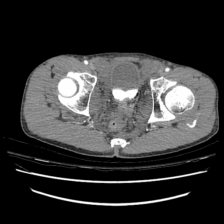

In [10]:
a = next(iter(val_data))
transform = t.ToPILImage()
img = transform(a['image'])
display(img)

In [11]:
model = timm.create_model('resnet18d', pretrained=False)

In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        model = timm.create_model('resnet18d', pretrained=False)
        model.fc = nn.Sequential(
                nn.Linear(in_features=512, out_features=100, bias=True),
                nn.BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
        )
        self.model = model
        self.fin = nn.Linear(100, 1)
        
    def forward(self, x):
        
        # extract features
        x = self.model(x)
        
        # output logits
        out = self.fin(x)

        return out

In [13]:
model = CNNModel().to('cuda')

In [14]:
BATCH_SIZE = 128
NUM_EPOCHS = 25
LR = 3e-5

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
bce = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([3.0]).to('cuda'))
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

In [16]:
train_dataloader = DataLoader(train_data,batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_data,batch_size = BATCH_SIZE, shuffle = False)

In [17]:
class MetricsCalculator:
    
    def __init__(self, mode = 'binary'):
        
        self.probabilities = []
        self.predictions = []
        self.targets = []
        
        self.mode = mode
    
    def update(self, logits, target):
        """
        Update the metrics calculator with predicted values and corresponding targets.
        
        Args:
            predicted (torch.Tensor): Predicted values.
            target (torch.Tensor): Ground truth targets.
        """
        if self.mode == 'binary':
            probabilities = torch.sigmoid(logits)
            predicted = (probabilities > 0.5)
        else:
            probabilities = F.softmax(logits, dim = 1)
            predicted = torch.argmax(probabilities, dim=1)
            
        self.probabilities.extend(probabilities.detach().cpu().numpy())
        self.predictions.extend(predicted.detach().cpu().numpy())
        self.targets.extend(target.detach().cpu().numpy())
    
    def reset(self):
        """Reset the stored predictions and targets."""
        
        self.probabilities = []
        self.predictions = []
        self.targets = []
    
    def compute_accuracy(self):
        """
        Compute the accuracy metric.
        
        Returns:
            float: Accuracy.
        """
        return accuracy_score(self.targets, self.predictions)
    
    def compute_f1(self):
        return f1_score(self.targets, self.predictions)
    
    def compute_auc(self):
        """
        Compute the AUC (Area Under the Curve) metric.
        
        Returns:
            float: AUC.
        """
        if self.mode == 'multi':
            return roc_auc_score(self.targets, self.probabilities, multi_class = 'ovo', labels=[0, 1, 2])
    
        else:
            return roc_auc_score(self.targets, self.probabilities)

In [18]:
train_acc = MetricsCalculator('binary')
val_acc = MetricsCalculator('binary')


In [19]:
prev_val_best_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    train_loss = 0.0
    val_loss = 0.0
    
    print(f'Epoch: [{epoch+1}/{NUM_EPOCHS}]')
        
    for batch_idx, batch_data in enumerate(tqdm(train_dataloader)):
        
        inputs = batch_data['image'].to('cuda')
        label = batch_data['label'].to('cuda')
        
        optimizer.zero_grad()
        out = model(inputs)
        loss = bce(out, label.float().unsqueeze(1))
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        train_acc.update(out, label)
    
    train_loss = train_loss/(batch_idx+1)
    
    # validation
    model.eval()
    running_loss = 0.0
    
    for batch_idx, batch_data in enumerate(tqdm(val_dataloader)):
                                                
        inputs = batch_data['image'].to('cuda')
        label = batch_data['label'].to('cuda')

        
        out = model(inputs)
        loss = bce(out, label.float().unsqueeze(1))
        
        
        val_loss += loss.item()
        val_acc.update(out, label)    
    
    val_loss = val_loss/(batch_idx+1)
    scheduler.step(val_loss)
    
    if val_loss < prev_val_best_loss:
        prev_val_best_loss = val_loss
        print("Validation Loss improved, Saving Model...")
        torch.save(model, f'best_resnet_18d_livdet.pth')
    if (epoch%5)==0:   
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict':scheduler.state_dict(),
            'train_loss':train_loss,
            'val_loss':val_loss,
            }, f'checkpoint_{epoch}_resnet_18_livdet.pth')

    
    
    # accuracy and auc data
    metrics_data = [
                    ["liver", 
                        train_acc.compute_accuracy(),
                        val_acc.compute_accuracy(),
                        train_acc.compute_auc(),
                        val_acc.compute_auc(),
                        train_acc.compute_f1(),
                        val_acc.compute_f1()]
                ]
    
    # verbose
    print('')
    print(tabulate(metrics_data, headers=["", "Train Acc", "Val Acc", "Train AUC", "Val AUC","Train F1","Val F1"]))
    
    print(f'\nMean Train Loss: {train_loss:.3f}')
    print(f'Mean Val Loss: {val_loss:.3f}\n')
    
    #reset metrics
    train_acc.reset()
    val_acc.reset()


Epoch: [1/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver      0.80687   0.749618     0.791543   0.899955    0.553004         0

Mean Train Loss: 0.898
Mean Val Loss: 1.006

Epoch: [2/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.890458   0.784733     0.954098   0.890033     0.80329   0.26943

Mean Train Loss: 0.622
Mean Val Loss: 0.896

Epoch: [3/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.913359   0.960305     0.978624   0.976939    0.846102  0.920732

Mean Train Loss: 0.504
Mean Val Loss: 0.517

Epoch: [4/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.941603   0.977099     0.990561   0.994958    0.893824  0.956268

Mean Train Loss: 0.420
Mean Val Loss: 0.391

Epoch: [5/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.961832    0.98626     0.993472    0.99733    0.928058  0.973294

Mean Train Loss: 0.362
Mean Val Loss: 0.339

Epoch: [6/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.965649   0.978626     0.993664   0.998025    0.934688  0.959064

Mean Train Loss: 0.331
Mean Val Loss: 0.293

Epoch: [7/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.975573    0.98626     0.996706   0.998684    0.952802  0.973294

Mean Train Loss: 0.295
Mean Val Loss: 0.257

Epoch: [8/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.979771   0.984733     0.997579    0.99923     0.96077  0.970414

Mean Train Loss: 0.274
Mean Val Loss: 0.225

Epoch: [9/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.983588   0.984733     0.998173   0.999503    0.967934  0.970414

Mean Train Loss: 0.256
Mean Val Loss: 0.217

Epoch: [10/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.987786   0.987786     0.999044   0.999826    0.976048   0.97619

Mean Train Loss: 0.236
Mean Val Loss: 0.213

Epoch: [11/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.987786   0.992366     0.999384   0.999901    0.975976  0.984985

Mean Train Loss: 0.226
Mean Val Loss: 0.185

Epoch: [12/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.988168   0.992366     0.999439          1    0.976709  0.984985

Mean Train Loss: 0.214
Mean Val Loss: 0.169

Epoch: [13/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.989695   0.998473     0.999358          1    0.979775   0.99696

Mean Train Loss: 0.203
Mean Val Loss: 0.151

Epoch: [14/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver      0.99313   0.992366     0.999633          1    0.986425  0.984985

Mean Train Loss: 0.190
Mean Val Loss: 0.155

Epoch: [15/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.990458   0.993893     0.999612          1    0.981245  0.987952

Mean Train Loss: 0.180
Mean Val Loss: 0.141

Epoch: [16/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver      0.99313   0.992366     0.999877          1    0.986425  0.984985

Mean Train Loss: 0.170
Mean Val Loss: 0.142

Epoch: [17/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.992748   0.998473     0.999734          1    0.985682   0.99696

Mean Train Loss: 0.168
Mean Val Loss: 0.125

Epoch: [18/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.991985          1     0.999492          1    0.984175         1

Mean Train Loss: 0.163
Mean Val Loss: 0.136

Epoch: [19/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.994656   0.998473      0.99996          1    0.989458   0.99696

Mean Train Loss: 0.151
Mean Val Loss: 0.111

Epoch: [20/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.995038   0.998473     0.999752          1    0.990189   0.99696

Mean Train Loss: 0.146
Mean Val Loss: 0.114

Epoch: [21/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.995802    0.99542     0.999973          1    0.991686  0.990937

Mean Train Loss: 0.139
Mean Val Loss: 0.122

Epoch: [22/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.996565   0.998473     0.999965          1    0.993197   0.99696

Mean Train Loss: 0.137
Mean Val Loss: 0.111

Epoch: [23/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.993893   0.998473     0.999726          1    0.987952   0.99696

Mean Train Loss: 0.140
Mean Val Loss: 0.102

Epoch: [24/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver     0.996947   0.998473     0.999989          1    0.993949   0.99696

Mean Train Loss: 0.126
Mean Val Loss: 0.103

Epoch: [25/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


         Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
-----  -----------  ---------  -----------  ---------  ----------  --------
liver      0.99542          1     0.999912          1    0.990937         1

Mean Train Loss: 0.126
Mean Val Loss: 0.103

